<a href="https://colab.research.google.com/github/rocodoco20/AI1week/blob/main/cuda_psy_2week.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [MY CODE] 환경 확인용

In [1]:
import torch

print(torch.__version__)
print(torch.version.cuda)  # PyTorch에서 사용하는 CUDA 버전
print(torch.cuda.is_available())  # GPU 사용 가능 여부


2.5.1+cu121
12.1
True


In [3]:
!pip install datasets sacremoses

In [18]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizerFast
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)


ds = load_dataset("stanfordnlp/imdb")
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')




def collate_fn(batch):
    max_len = 400  # 최대 시퀀스 길이
    texts, labels = [], []

    for row in batch:
        # 텍스트에 대한 토큰화 및 패딩
        encoding = tokenizer(row['text'], truncation=True, max_length=max_len, padding='max_length')
        texts.append(torch.LongTensor(encoding['input_ids']))  # 패딩된 input_ids
        labels.append(row['label'])  # 텍스트의 실제 클래스 레이블을 사용

    # 텍스트 배치 생성
    texts = torch.stack(texts, dim=0)  # batch_size x max_len

    # 레이블은 단순히 텍스트의 클래스 레이블
    labels = torch.LongTensor(labels)  # batch_size 크기의 레이블

    return texts, labels

# 데이터 로더 정의
train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


## [MY CODE] labels.append(row['label'])  텍스트의 실제 클래스 레이블을 사용 안하니깐 -값이 나타나서 학습이 되질 않았음


In [19]:
from torch import nn
from math import sqrt


class SelfAttention(nn.Module):
  def __init__(self, input_dim, d_model):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model

    self.wq = nn.Linear(input_dim, d_model)
    self.wk = nn.Linear(input_dim, d_model)
    self.wv = nn.Linear(input_dim, d_model)
    self.dense = nn.Linear(d_model, d_model)

    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x, mask):
    q, k, v = self.wq(x), self.wk(x), self.wv(x)
    score = torch.matmul(q, k.transpose(-1, -2)) # (B, S, D) * (B, D, S) = (B, S, S)
    score = score / sqrt(self.d_model)

    if mask is not None:
      score = score + (mask * -1e9)

    score = self.softmax(score)
    result = torch.matmul(score, v)
    result = self.dense(result)

    return result

In [20]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.dff = dff

    self.sa = SelfAttention(input_dim, d_model)
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )

  def forward(self, x, mask):
    x = self.sa(x, mask)
    x = self.ffn(x)

    return x

In [21]:
import numpy as np


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400
print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


In [22]:
from math import sqrt

# 모델 정의
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, dff):
        super().__init__()

        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_layers = n_layers
        self.dff = dff

        # 임베딩 및 포지셔널 인코딩
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = nn.parameter.Parameter(
            positional_encoding(512, d_model), requires_grad=False
        )

        # Transformer 레이어
        self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff) for _ in range(n_layers)])

        # 분류를 위한 최종 선형 레이어 (이진 분류로 1로 설정)
        self.classification = nn.Linear(d_model, 1)  # 이진 분류이므로 출력 차원 1로 설정

    def forward(self, x):
        mask = (x == tokenizer.pad_token_id)
        mask = mask[:, None, :]
        seq_len = x.shape[1]

        x = self.embedding(x)
        x = x * sqrt(self.d_model)  # 스케일링(scaling) 추가
        x = x + self.pos_encoding[:, :seq_len]

        for layer in self.layers:
            x = layer(x, mask)

        x = x[:, 0]  # [batch_size, d_model] 형태로 첫 번째 token만 추출
        x = self.classification(x)  # 출력 차원 1로

        # 이진 분류에서는 sigmoid를 사용하여 확률 값으로 변환
        x = torch.sigmoid(x)

        return x

# 모델 정의
model = TextClassifier(len(tokenizer), 32, 2, 32)

In [23]:
from torch.optim import Adam

lr = 0.001
model = model.to('cuda')
loss_fn = nn.BCEWithLogitsLoss() # 손실 함수 정의

optimizer = Adam(model.parameters(), lr=lr)

In [24]:
import numpy as np
import matplotlib.pyplot as plt


def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    # preds = torch.argmax(preds, dim=-1)
    preds = (preds > 0).long()[..., 0]

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [25]:
train_accs, test_accs = [], []  # 학습 정확도 리스트 # 테스트 정확도 리스트

n_epochs = 50

for epoch in range(n_epochs):
    total_loss = 0.
    model.train()
    for data in train_loader:
        model.zero_grad()
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda').float()

        preds = model(inputs)[..., 0]
        loss = loss_fn(preds, labels)
        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

    with torch.no_grad():
        model.eval()

        # 훈련 데이터와 테스트 데이터에 대한 정확도 계산
        train_acc = accuracy(model, train_loader)
        test_acc = accuracy(model, test_loader)

        # 정확도를 리스트에 추가
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        # 각 에포크마다 출력
        print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

Epoch   0 | Train Loss: 264.32551741600037
=========> Train acc: 0.500 | Test acc: 0.500
Epoch   1 | Train Loss: 250.57216846942902
=========> Train acc: 0.500 | Test acc: 0.500
Epoch   2 | Train Loss: 243.1417135000229
=========> Train acc: 0.500 | Test acc: 0.500
Epoch   3 | Train Loss: 238.0319870710373
=========> Train acc: 0.500 | Test acc: 0.500
Epoch   4 | Train Loss: 234.6935264468193
=========> Train acc: 0.526 | Test acc: 0.526
Epoch   5 | Train Loss: 231.8121556341648
=========> Train acc: 0.556 | Test acc: 0.557
Epoch   6 | Train Loss: 230.11310628056526
=========> Train acc: 0.543 | Test acc: 0.542
Epoch   7 | Train Loss: 228.99619841575623
=========> Train acc: 0.524 | Test acc: 0.526
Epoch   8 | Train Loss: 226.36965703964233
=========> Train acc: 0.516 | Test acc: 0.517
Epoch   9 | Train Loss: 224.63925096392632
=========> Train acc: 0.525 | Test acc: 0.524
Epoch  10 | Train Loss: 224.11415445804596
=========> Train acc: 0.548 | Test acc: 0.549
Epoch  11 | Train Loss: 2

## [LOG] 결과 출력

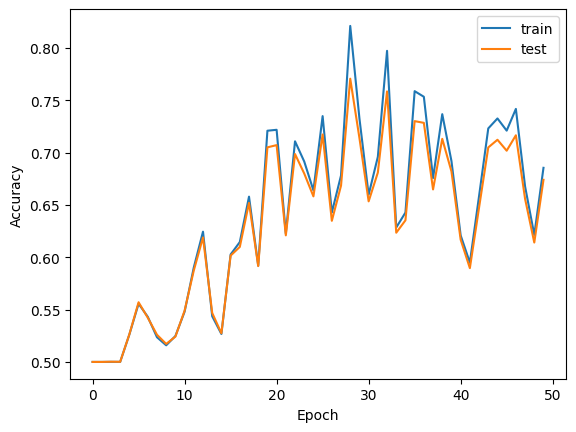

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def plot_acc(train_acc, test_acc, label1='train', label2='test'):
    x = np.arange(len(train_acc))  # 정확도 리스트의 길이를 구합니다.
    plt.plot(x, train_acc, label=label1)
    plt.plot(x, test_acc, label=label2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 학습이 끝난 후, train_accs와 test_accs를 plot_acc 함수에 전달
plot_acc(train_accs, test_accs)